In [1]:
import sys
if 'taxcalc' not in sys.modules:
    %pip install taxcalc &> /dev/null  # dev/null suppresses output

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import taxcalc as tc

# Reform 1: TCJA full-package extension
reform1 = tc.Policy.read_json_reform('./docs/recipes/_static/ext_full.json')

# Reform 2: TCJA extension except for 
reform2 = tc.Policy.read_json_reform('./docs/recipes/_static/ext_without_qbid.json')

# specify Policy object for pre-TCJA policy
bpolicy = tc.Policy()
bpolicy.implement_reform(reform1, print_warnings=False, raise_errors=False)
assert not bpolicy.parameter_errors

# specify Policy object for TCJA reform relative to pre-TCJA policy
rpolicy = tc.Policy()
rpolicy.implement_reform(reform1, print_warnings=False, raise_errors=False)
assert not rpolicy.parameter_errors
rpolicy.implement_reform(reform2, print_warnings=False, raise_errors=False)
assert not rpolicy.parameter_errors

# specify Calculator objects using bpolicy and rpolicy
recs = tc.Records.cps_constructor()
calc1 = tc.Calculator(policy=bpolicy, records=recs)
calc2 = tc.Calculator(policy=rpolicy, records=recs)

CYR = 2026

# calculate for specified CYR
calc1.advance_to_year(CYR)
calc1.calc_all()
calc2.advance_to_year(CYR)
calc2.calc_all()

# compare aggregate individual income tax revenue in cyr
iitax_rev1 = calc1.weighted_total('iitax')
iitax_rev2 = calc2.weighted_total('iitax')

# construct reform-vs-baseline difference table with results for income deciles
diff_table = calc1.difference_table(calc2, 'weighted_deciles', 'iitax')
assert isinstance(diff_table, pd.DataFrame)
diff_extract = pd.DataFrame()
dif_colnames = ['count', 'tax_cut', 'tax_inc',
                'tot_change', 'mean', 'pc_aftertaxinc']
ext_colnames = ['funits(#m)', 'taxfall(#m)', 'taxrise(#m)',
                'agg_diff($b)', 'mean_diff($)', 'aftertax_income_diff(%)']
for dname, ename in zip(dif_colnames, ext_colnames):
    diff_extract[ename] = diff_table[dname]

In [3]:
# print total revenue estimates for cyr
# (estimates in billons of dollars)
print('{}_REFORM1_iitax_rev($B) = {:.1f}'.format(CYR, iitax_rev1 * 1e-9))
print('{}_REFORM2_iitax_rev($B) = {:.1f}'.format(CYR, iitax_rev2 * 1e-9))
print('======')
print('Additional rev($B) from REFORM2 compared to REFORM1 = {:.1f}'.format((iitax_rev2-iitax_rev1) * 1e-9))

2026_REFORM1_iitax_rev($B) = 2024.5
2026_REFORM2_iitax_rev($B) = 2036.5
Additional rev($B) from REFORM2 compared to REFORM1 = 12.0


Next, we plot the MTR wrt S-corporation/partnership income (with code 'e26270').

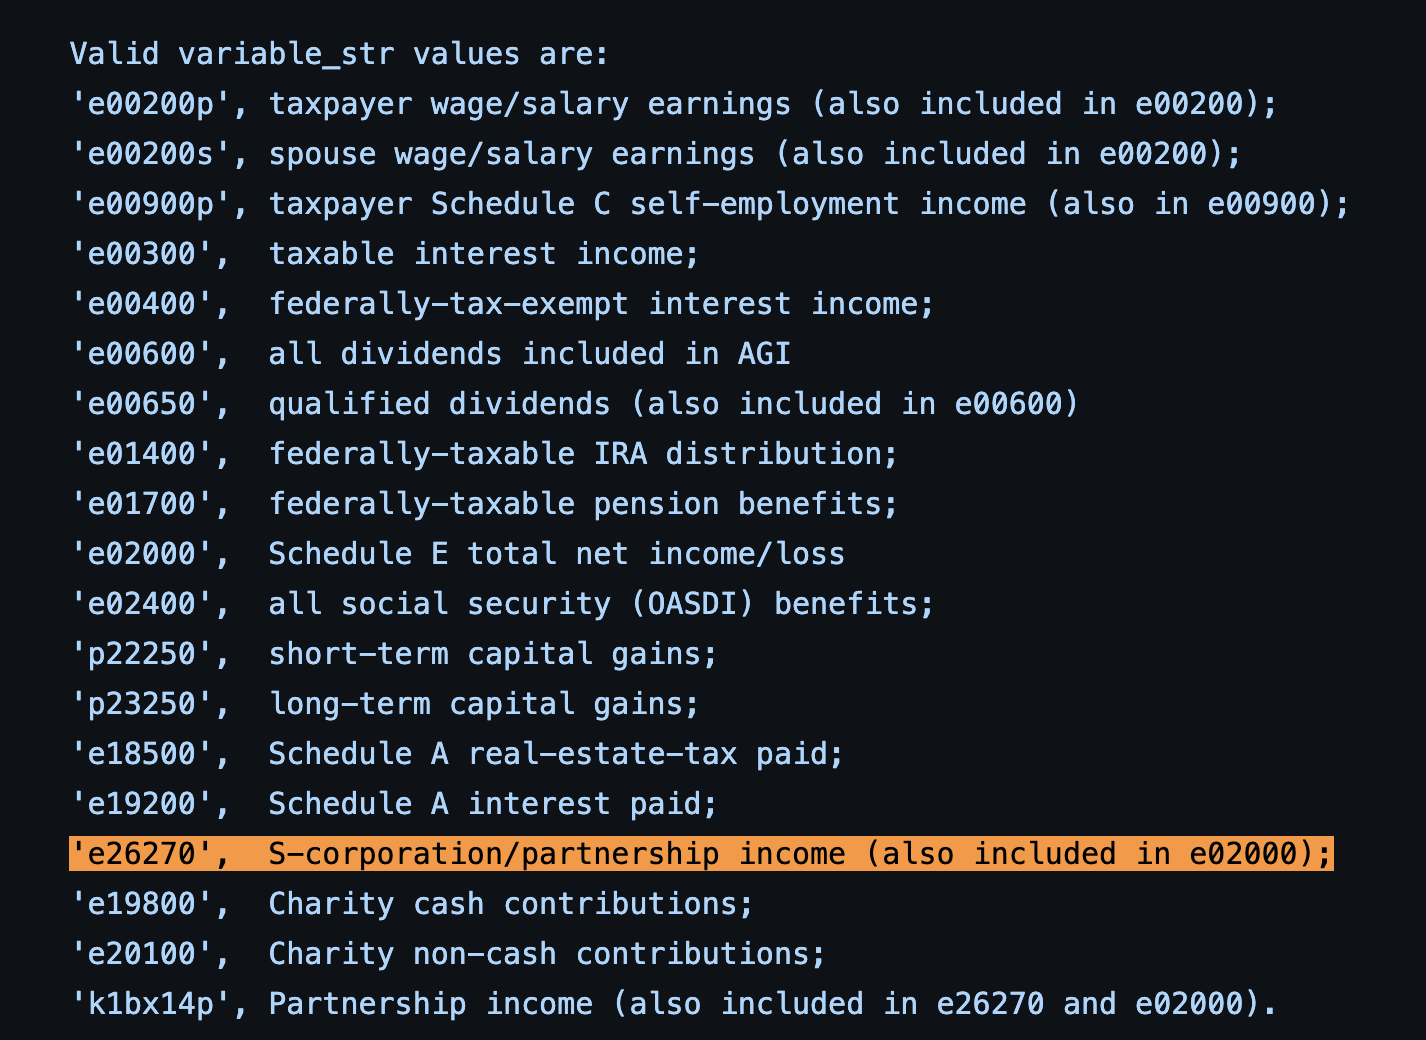

In [4]:
(_, _, mtr1) = calc1.mtr('e26270', calc_all_already_called=True,
                         wrt_full_compensation=False)

(_, _, mtr2) = calc2.mtr('e26270', calc_all_already_called=True,
                         wrt_full_compensation=False)

vdf = calc1.dataframe(['s006', 'e26270', 'e00200'])
vdf['mtr1'] = mtr1
vdf['mtr2'] = mtr2
vdf['price1'] = 1.0 + mtr1
vdf['price2'] = 1.0 + mtr2
vdf['atinc1'] = calc1.array('aftertax_income')
vdf['atinc2'] = calc2.array('aftertax_income')

# group filing units into earnings groups with different response elasticities
# (note earnings groups are just an example based on no empirical results)
earnings_bins = [-9e99, 50e3, 9e99]  # two groups: below and above $50,000
vdf = tc.add_income_table_row_variable(vdf, 'e26270', earnings_bins)

In [5]:
data = tc.utils.mtr_graph_data(vdf, 2026,
                   mars='ALL',
                   mtr_measure='itax',
                   mtr_variable='e26270',
                   mtr_wrt_full_compen=False,
                   income_measure='wages',
                   pop_quantiles=False,
                   dollar_weighting=False)

df = data['lines'].rename(columns={"base": "Reform 1", "reform": "Reform 2"})

<Axes: title={'center': 'QBI marginal tax rate by wage/salary income percentile'}>

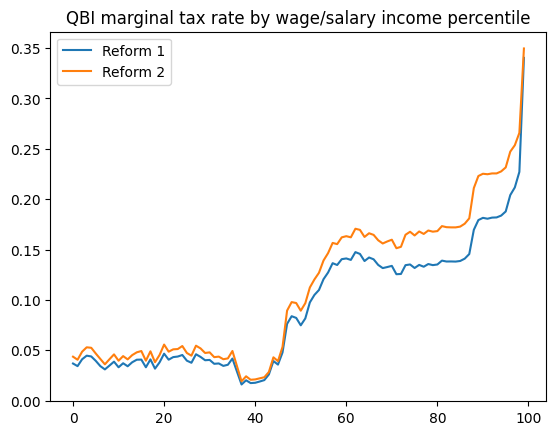

In [6]:
df.plot(title = "QBI marginal tax rate by wage/salary income percentile")